# Setup

In [1]:
%pip install earthaccess h5netcdf --quiet --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
import landsatxplore
import pandas as pd
from landsatxplore import errors
from landsatxplore.earthexplorer import EarthExplorer
from landsatxplore.api import API
import os
import json

In [3]:
username = 'aprilianidiar'
password = '28Maret1991!100423'

api = API(username, password)

response = api.request(endpoint="dataset-catalogs")
print(response)

{'EE': 'EarthExplorer', 'GV': 'GloVis', 'HDDS': 'HDDS Explorer'}


In [4]:
results = []

datasets = ['landsat_tm_c2_l2']

for dataset in datasets:
    scenes = api.search(
        dataset= dataset,
        latitude= 34.25,
        longitude=66.64,
        start_date= '1990-01-01',
        end_date= '1992-12-31',
        max_cloud_cover=20,
        max_results=10000,
    )
    results.extend(scenes)

In [5]:
for scene in scenes:
    print(scene['acquisition_date'].strftime('%Y-%m-%d'))
    fname = f"{scene['landsat_product_id']}.geojson"
    with open(fname, "w") as f:
        json.dump(scene['spatial_coverage'].__geo_interface__, f)

1992-10-18
1992-09-16
1992-08-31
1992-08-15
1992-07-30
1992-06-28
1992-05-11
1992-03-08
1992-02-21
1992-02-05
1992-01-20
1991-10-16
1991-09-14
1991-08-29
1991-08-13
1991-06-26
1991-06-10
1991-05-25
1991-04-23
1991-02-18
1991-01-17
1990-12-16
1990-10-29
1990-10-13
1990-09-11
1990-08-26
1990-07-25
1990-06-23
1990-06-07
1990-05-22
1990-04-04
1990-03-03
1990-02-15
1990-01-14


In [6]:
df_scenes = pd.DataFrame(results)
df_scenes['tier'] = [int(x[-1]) for x in df_scenes["display_id"]]
df_scenes['satellite'] = [int(str(x)[-1]) for x in df_scenes['satellite']]

df_scenes = df_scenes[['display_id', 'wrs_path', 'wrs_row', 'satellite', 'cloud_cover', 'tier', 'acquisition_date']]
df_scenes.columns = ['id', 'path', 'row', 'satellite', 'cloud_cover', 'tier', 'date']

df_scenes['year'] = pd.to_datetime(df_scenes['date']).dt.year
df_scenes['month'] = pd.to_datetime(df_scenes['date']).dt.month

df_scenes.sort_values('date', ascending=True, inplace=True)

print(df_scenes)

                                          id  path  row  satellite  \
33  LT05_L2SP_154036_19900114_20200916_02_T1   154   36          5   
32  LT05_L2SP_154036_19900215_20200916_02_T1   154   36          5   
31  LT05_L2SP_154036_19900303_20200916_02_T1   154   36          5   
30  LT05_L2SP_154036_19900404_20200916_02_T1   154   36          5   
29  LT05_L2SP_154036_19900522_20200916_02_T1   154   36          5   
28  LT05_L2SP_154036_19900607_20200915_02_T1   154   36          5   
27  LT05_L2SP_154036_19900623_20200916_02_T1   154   36          5   
26  LT05_L2SP_154036_19900725_20200916_02_T1   154   36          5   
25  LT05_L2SP_154036_19900826_20200916_02_T1   154   36          5   
24  LT05_L2SP_154036_19900911_20200915_02_T1   154   36          5   
23  LT05_L2SP_154036_19901013_20200915_02_T1   154   36          5   
22  LT05_L2SP_154036_19901029_20200915_02_T1   154   36          5   
21  LT05_L2SP_154036_19901216_20200915_02_T1   154   36          5   
20  LT05_L2SP_154036

In [7]:
# filtering scenes
# adding years data 
df_scenes = df_scenes.groupby('year').first().reset_index()
print(df_scenes)

   year                                        id  path  row  satellite  \
0  1990  LT05_L2SP_154036_19900114_20200916_02_T1   154   36          5   
1  1991  LT05_L2SP_154036_19910117_20200915_02_T1   154   36          5   
2  1992  LT05_L2SP_154036_19920120_20200914_02_T1   154   36          5   

   cloud_cover  tier       date  month  
0            1     1 1990-01-14      1  
1            2     1 1991-01-17      1  
2            1     1 1992-01-20      1  


In [8]:
# downloading scenes
ee = EarthExplorer(username, password)

for i,ID in enumerate(df_scenes.id):
    print("year : {} | ID: {}".format(df_scenes.year[i],ID))

    try:
        ee.download(ID, output_dir='./data')
        print('{} successful'.format(ID))

    except: 
        if os.path.isfile('./data/{}.tar'.format(ID)):
            print('{} error but file exists'.format(ID))
        else:
            print('{} error'.format(ID))
    print()
ee.logout()

year : 1990 | ID: LT05_L2SP_154036_19900114_20200916_02_T1


100%|██████████| 620M/620M [12:40<00:00, 855kB/s]   


None of the archived ids succeeded! Update necessary!
LT05_L2SP_154036_19900114_20200916_02_T1 error but file exists

year : 1991 | ID: LT05_L2SP_154036_19910117_20200915_02_T1


100%|██████████| 644M/644M [00:22<00:00, 29.6MB/s]  


None of the archived ids succeeded! Update necessary!
LT05_L2SP_154036_19910117_20200915_02_T1 error but file exists

year : 1992 | ID: LT05_L2SP_154036_19920120_20200914_02_T1


667MB [07:31, 1.55MB/s]                             


None of the archived ids succeeded! Update necessary!
LT05_L2SP_154036_19920120_20200914_02_T1 error but file exists



In [9]:
import tarfile

tar = tarfile.open('./data/{}.tar'.format(ID))
tar.extractall('./data/{}'.format(ID))
tar.close()

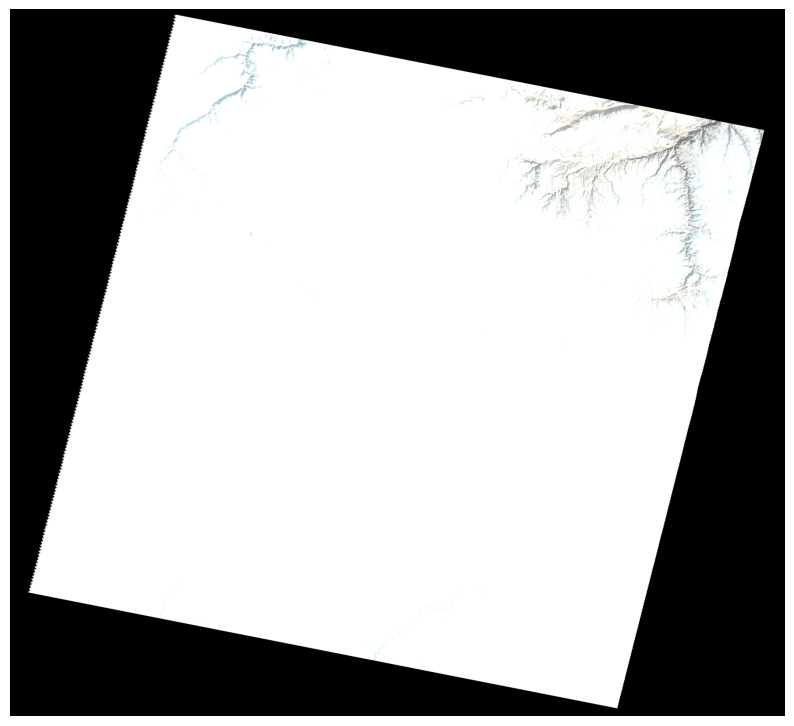

In [10]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

blue = tiff.imread('./data/{}/{}_SR_B2.TIF'.format(ID, ID))
green = tiff.imread('./data/{}/{}_SR_B3.TIF'.format(ID, ID))
red = tiff.imread('./data/{}/{}_SR_B4.TIF'.format(ID, ID))

RGB = np.dstack((red, green, blue))
RGB = np.clip(RGB*0.0000275-0.2, 0, 1)
RGB = np.clip(RGB,0,0.2)/0.2

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(RGB)
ax.set_axis_off()

# Stacking Bands of the Image

In [11]:
import rasterio
from rasterio.merge import merge

mosaic = []
images = [".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B1.TIF", ".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B2.TIF"]
result = 'mosaic.tif'

for img in images:
    src = rasterio.open(img)
    mosaic.append(src)

mosaic_meta = src.meta.copy()
print(mosaic_meta)


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\april\AppData\Local\Temp\ipykernel_14680\4055168606.py:5: SyntaxWarning: invalid escape sequence '\d'
  images = [".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B1.TIF", ".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B2.TIF"]
C:\Users\april\AppData\Local\Temp\ipykernel_14680\4055168606.py:5: SyntaxWarning: invalid escape sequence '\d'
  images = [".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B1.TIF", ".\data\LC08_L2SP_206023_20221118_20221128_02_T1\LC08_L2SP_206023_20221118_20221128_02_T1_SR_B2.TIF"]


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7801, 'height': 7901, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(30.0, 0.0, 542985.0,
       0.0, -30.0, 6004215.0)}


In [12]:
mosaic_img, mosaic_transform = merge(mosaic)
mosaic_meta.update({"driver": "GTiff", 
                    "height": mosaic_img.shape[1],
                    "width": mosaic_img.shape[2],
                    "transform": mosaic_transform,
                    "crs": src.crs
                    })
with rasterio.open(result, "w", **mosaic_meta) as dest:
                   dest.write(mosaic_img)

In [13]:
mosaic_img

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

In [ ]:
# stacking images



# Inserting Training Data

In [14]:
import fiona
import geopandas as gpd

with fiona.open("./afg/afg_train.shp") as features:
    print(len(features))
    gdf = gpd.GeoDataFrame.from_features(features)
    print(gdf.head())

30457
                    geometry  lc_id  id_to_join
0  POINT (64.11093 29.42818)      6           0
1  POINT (62.41612 29.39997)      6           1
2  POINT (62.46731 29.40250)      6           2
3  POINT (62.51852 29.40501)      6           3
4  POINT (62.56973 29.40750)      6           4


In [15]:
import fiona
import geopandas as gpd

with fiona.open("./afg/Training.shp") as features:
    print(len(features))
    gdf = gpd.GeoDataFrame.from_features(features)
    print(gdf.head())

41413
                    geometry  OBJECTID Premitives  year    Sub  PLOTID  \
0  POINT (64.11093 29.42818)         3        BRS  2018   Soil       1   
1  POINT (62.41612 29.39997)         4        BRS  2018   Soil       2   
2  POINT (62.46731 29.40250)         5        BRS  2018   Soil       3   
3  POINT (62.51852 29.40501)         6        BSD  2018  Dunes       4   
4  POINT (62.56973 29.40750)         7        BSD  2018  Dunes       5   

  Remarks  landcover_  
0    None          10  
1    None           0  
2    None           0  
3    None           0  
4    None           0  


# Get Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz

In [17]:
import pandas as pd

training = './afg/Training.shp'
data = pd.DataFrame({
    'urban area': training.data[:,0],
    'orchards': training[:,1],
    'agriculture': training[:,2],
    'irrigated': training[:,3],
    'rainfed': training[:,4],
    'forest': training[:,5],
    'rageland': training[:,6],
    'barren': training[:,7],
    'marshes': training[:,8],
    'waterbodies': training[:,9],
    'permanent_snow': training[:,10],
})

classifier = RandomForestClassifier(
    n_estimators=200,
    criterion='landcover_',
    max_features=12,
)


AttributeError: 'str' object has no attribute 'data'